In [1]:
import os
import sys
import math

import h5py
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image

%matplotlib inline

/home/tenzin/ML/env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Let's discover the different labels

In [17]:
data_path = '../../data/a0409a00-8-dataset_dp'
train = pd.read_csv(data_path + '/train.csv')
print(train.head())
test = pd.read_csv(data_path + '/test.csv')
print(train.label.nunique(),'labels')
label_counts = train.label.value_counts()
print(label_counts)

   image_id    label
0  train_1a     rice
1  train_1b    candy
2  train_1c      jam
3  train_1d   coffee
4  train_2a  vinegar
25 labels
candy          242
chocolate      199
juice          196
coffee         194
tea            184
cereal         181
water          170
jam            157
spices         135
honey          120
chips          118
soda           115
pasta          112
tomatosauce    111
nuts           109
milk           105
cake           105
vinegar        102
rice            97
oil             93
beans           88
sugar           77
fish            71
flour           71
corn            63
Name: label, dtype: int64


### Let's see the distribution of each class in the dataset

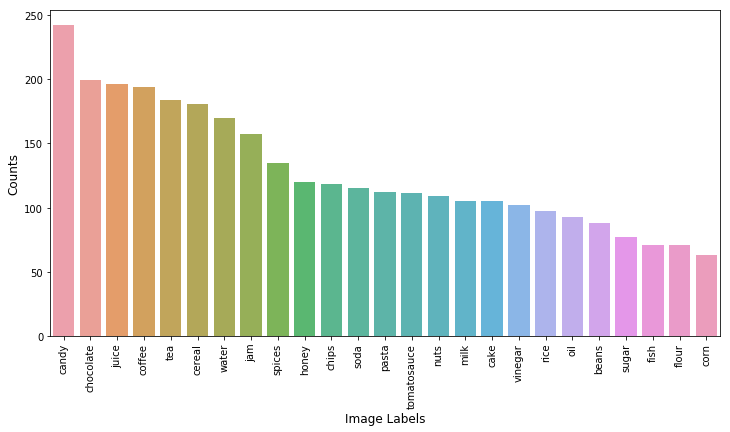

In [18]:
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Labels', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

### Put each training image into a sub folder corresponding to its label after converting to JPG format

In [19]:
for img in tqdm(train.values):
    filename=img[0]
    label=img[1]
    src=os.path.join(data_path,'train_img',filename+'.png')
    label_dir=os.path.join(data_path,'train',label)
    dest=os.path.join(label_dir,filename+'.jpg')
    im=Image.open(src)
    rgb_im=im.convert('RGB')
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
    rgb_im.save(dest)

100%|██████████| 3215/3215 [00:32<00:00, 99.28it/s] 


### Some agile data augmentation (to prevent overfitting) + class balance

In [20]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

class_size=600

src_train_dir=os.path.join(data_path,'train')
dest_train_dir=os.path.join(data_path,'train')
it=0
for count in label_counts.values:
    #nb of generations per image for this class label in order to make it size ~= class_size
    ratio=math.floor(class_size/count)-1
    # print(count,count*(ratio+1))
    dest_lab_dir=os.path.join(dest_train_dir,label_counts.index[it])
    src_lab_dir=os.path.join(src_train_dir,label_counts.index[it])
    if not os.path.exists(dest_lab_dir):
        os.makedirs(dest_lab_dir)
    for file in os.listdir(src_lab_dir):
        img=load_img(os.path.join(src_lab_dir,file))
        #img.save(os.path.join(dest_lab_dir,file))
        x=img_to_array(img) 
        x=x.reshape((1,) + x.shape)
        i=0
        for batch in datagen.flow(x, batch_size=1,save_to_dir=dest_lab_dir, save_format='jpg'):
            i+=1
            if i > ratio:
                break 
    it=it+1

### Let's check the new distribution

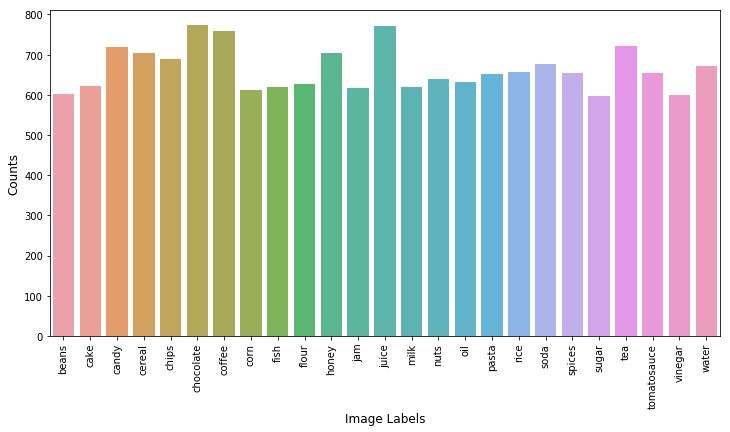

In [35]:
labels = []
labels_count = []
for dirpath, dirnames, filenames in os.walk(dest_train_dir):
    count = 0
    label=''
    for filename in [f for f in filenames if f.endswith(".jpg")]:
        label = os.path.split(dirpath)[1]
        count += 1
    if count > 0:
        labels.append(label)
        labels_count.append(count)

# sorted the labels
sorted_zipped_labels_count = sorted(zip(labels, labels_count), key=lambda l: l[0])
labels, labels_count = zip(*sorted_zipped_labels_count)
labels = list(labels)
labels_count = list(labels_count)

plt.figure(figsize = (12,6))
sns.barplot(labels, labels_count, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Labels', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()